In [9]:
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree, ensemble, svm

# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, InputLayer, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import RMSprop

%load_ext autoreload
%autoreload 2

from utils import *
from dataset_loader import DatasetLoader
from plot_confusion_matrix import plot_confusion_matrix



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Audioset Embeddings

In [10]:
FEATURES_DIR = "../features/audioset_em/"
META_FILE = '../meta/esc50.csv'


### Load dataset

In [11]:
dataset_loader = DatasetLoader(FEATURES_DIR, META_FILE, test_fold = 1, category_idx=1 )
dataset_loader.load()


Time taken to load = 0.53


In [30]:
X_train, y_train = dataset_loader.get_train_data()
X_test, y_test = dataset_loader.get_test_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 5, 128), (320,), (80, 5, 128), (80,))

### Visualize features


In [97]:
def plot_features(ax, dataset_loader, idx):
    row = dataset_loader.df_train.iloc[idx]
    feat = row.feat
    category = row.category
    filename = row.filename

    # convert hop size to time
    hop_to_time = np.arange(feat.shape[1]) * 256.0 / 22050.0
    hop_to_time = hop_to_time.round(decimals=2)
    # plot
    p = ax.imshow(feat.T, aspect='auto')
    ax.set_title(category)
    ax.set_xlabel('time')
    plt.colorbar(p, ax=ax)


Text(0.5,0.98,'Audioset embeddings')

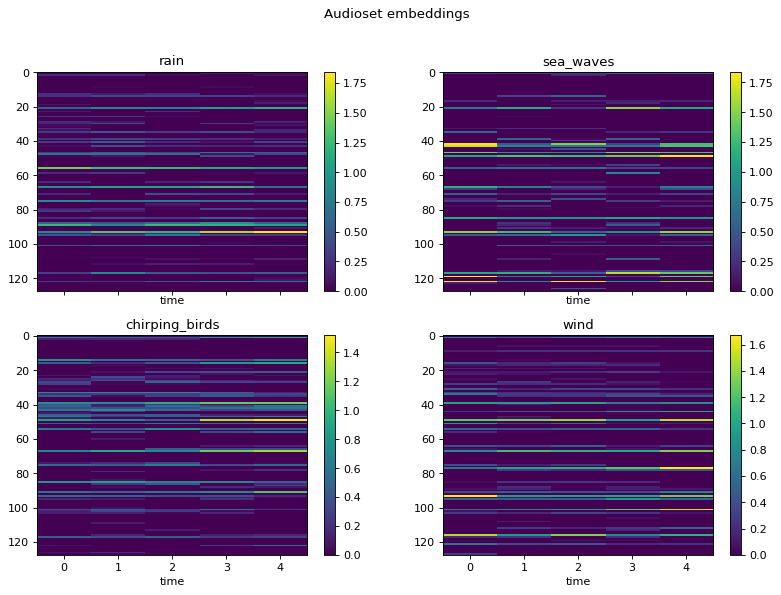

In [96]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, dpi=80)
plot_features(ax[0,0], dataset_loader, 0)
plot_features(ax[0,1], dataset_loader, 8)
plot_features(ax[1,0], dataset_loader, 15)
plot_features(ax[1,1], dataset_loader, 20)
# fig.tight_layout()
fig.suptitle('Audioset embeddings')

## Method 1: 
Each sample is 5s. Audioset embeddings are created for 1s of audio.  
We'll take mean and std of five 1 second embeddings.

In [14]:
# get mean std over time
X_train = np.concatenate( [X_train.mean(axis=1), X_train.std(axis=1)], axis=1)
X_test = np.concatenate([X_test.mean(axis=1), X_test.std(axis=1)], axis=1)
print(X_train.shape, X_test.shape)

(320, 256) (80, 256)


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:143: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


In [ ]:
### Transform input data for Audioset Embedding 

# take 1s as one example data
X_train_1s = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test_1s = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

y_train_1s = np.repeat(y_train, 5)
y_test_1s = np.repeat(y_test, 5)

X_train, X_test = X_train_1s, X_test_1s
y_train, y_test = y_train_1s, y_test_1s

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


### Random forest

In [18]:
clf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=25)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.8625)

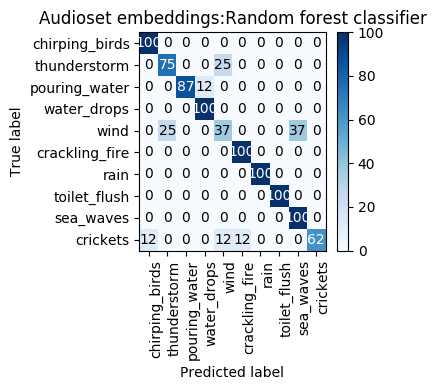

In [22]:
y_test_pred = clf.predict(X_test)

plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize=True, figsize=(4,4),
                      classes=dataset_loader.classes, title='Audioset embeddings:Random forest classifier')

### MLP

In [24]:
# keras training settings
batch_size = 32
num_classes = 50
epochs = 50

# mlp
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
Total para

In [25]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

history = model.fit(X_train, y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2,
                validation_data=(X_test, y_test_cat))

Train on 320 samples, validate on 80 samples
Epoch 1/50
 - 0s - loss: 3.7434 - acc: 0.0781 - val_loss: 3.2969 - val_acc: 0.1875
Epoch 2/50
 - 0s - loss: 2.8793 - acc: 0.1344 - val_loss: 2.1805 - val_acc: 0.4625
Epoch 3/50
 - 0s - loss: 2.2875 - acc: 0.2000 - val_loss: 1.7294 - val_acc: 0.6250
Epoch 4/50
 - 0s - loss: 1.9378 - acc: 0.3219 - val_loss: 1.3633 - val_acc: 0.6500
Epoch 5/50
 - 0s - loss: 1.6126 - acc: 0.4219 - val_loss: 1.0469 - val_acc: 0.7000
Epoch 6/50
 - 0s - loss: 1.3170 - acc: 0.5156 - val_loss: 0.8332 - val_acc: 0.8125
Epoch 7/50
 - 0s - loss: 1.1421 - acc: 0.5906 - val_loss: 0.6588 - val_acc: 0.8250
Epoch 8/50
 - 0s - loss: 0.9792 - acc: 0.6406 - val_loss: 0.6504 - val_acc: 0.8125
Epoch 9/50
 - 0s - loss: 0.8807 - acc: 0.6781 - val_loss: 0.5429 - val_acc: 0.8625
Epoch 10/50
 - 0s - loss: 0.7823 - acc: 0.7406 - val_loss: 0.5814 - val_acc: 0.8250
Epoch 11/50
 - 0s - loss: 0.6821 - acc: 0.7688 - val_loss: 0.5220 - val_acc: 0.8625
Epoch 12/50
 - 0s - loss: 0.6469 - acc: 

## Method 2: 
We'll treat 1s audio segment as a training sample.  
We'll get 5 times the training data, but each training sample may not encode enough information for classification.

In [26]:
FEATURES_DIR = "../features/audioset_em/"
META_FILE = '../meta/esc50.csv'


### Load dataset

In [36]:
dataset_loader = DatasetLoader(FEATURES_DIR, META_FILE, test_fold = 1, category_idx=1 )
dataset_loader.load()


Time taken to load = 0.16


In [37]:
X_train, y_train = dataset_loader.get_train_data()
X_test, y_test = dataset_loader.get_test_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 5, 128), (320,), (80, 5, 128), (80,))

In [38]:
### Transform input data for Audioset Embedding 

# take 1s as one example data
X_train_1s = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test_1s = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

y_train_1s = np.repeat(y_train, 5)
y_test_1s = np.repeat(y_test, 5)

X_train, X_test = X_train_1s, X_test_1s
y_train, y_test = y_train_1s, y_test_1s

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600, 128) (400, 128) (1600,) (400,)


### MLP

In [57]:
# keras training settings
batch_size = 32
num_classes = 50
epochs = 30

# mlp
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                6450      
Total para

In [58]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

history = model.fit(X_train, y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                verbose=2,
                validation_data=(X_test, y_test_cat))

Train on 1600 samples, validate on 400 samples
Epoch 1/30
 - 1s - loss: 3.0671 - acc: 0.1094 - val_loss: 2.0096 - val_acc: 0.4075
Epoch 2/30
 - 0s - loss: 2.0603 - acc: 0.2712 - val_loss: 1.3461 - val_acc: 0.5900
Epoch 3/30
 - 0s - loss: 1.6732 - acc: 0.3912 - val_loss: 1.0787 - val_acc: 0.6100
Epoch 4/30
 - 0s - loss: 1.4106 - acc: 0.4831 - val_loss: 0.9327 - val_acc: 0.6275
Epoch 5/30
 - 0s - loss: 1.3039 - acc: 0.5194 - val_loss: 0.8728 - val_acc: 0.6975
Epoch 6/30
 - 0s - loss: 1.2003 - acc: 0.5531 - val_loss: 0.8127 - val_acc: 0.7125
Epoch 7/30
 - 0s - loss: 1.0881 - acc: 0.6025 - val_loss: 0.7861 - val_acc: 0.7200
Epoch 8/30
 - 0s - loss: 1.0474 - acc: 0.6312 - val_loss: 0.7625 - val_acc: 0.7475
Epoch 9/30
 - 0s - loss: 0.9741 - acc: 0.6469 - val_loss: 0.7512 - val_acc: 0.7600
Epoch 10/30
 - 0s - loss: 0.9323 - acc: 0.6494 - val_loss: 0.7526 - val_acc: 0.7500
Epoch 11/30
 - 0s - loss: 0.8768 - acc: 0.6781 - val_loss: 0.7259 - val_acc: 0.7675
Epoch 12/30
 - 0s - loss: 0.8629 - acc

In [59]:
y_train_pred_1s = model.predict(X_train)
y_test_pred_1s = model.predict(X_test)

def mean_prob_5(y_pred):
    y_pred = y_pred.reshape(int(y_pred.shape[0]/5), 5, y_pred.shape[1])
    y_pred = y_pred.mean(axis=1)
    return y_pred.argmax(axis=1)


y_train_pred = mean_prob_5(y_train_pred_1s)
y_test_pred = mean_prob_5(y_test_pred_1s)

np.mean(y_train_pred == y_train[::5]), np.mean(y_test_pred == y_test[::5])

(0.965625, 0.8625)